In [1]:
import pandas as pd
import geopandas
import matplotlib.pyplot as plt
import numpy as np
import os
import requests
import gzip
import shutil
import glob
import folium
import matplotlib.patches as mpatches
from scipy import stats

%matplotlib inline
%config InlineBackend.figure_format ='retina'

from config import *

statesShp = geopandas.read_file(dataFolder + "/cb_2018_us_state_500k.zip").to_crs(3857)
statesShp = statesShp[['GEOID', 'STUSPS', 'NAME', 'geometry']]

def plotUS():
    ax = statesShp.plot(figsize=(20, 10), color='#e4e4e4', edgecolor='black', linewidth=2)
    ax.axis('equal')
    plt.xlim(-1.5e7, -0.7e7)
    plt.ylim(2.5e6, 7e6)
    return ax

def plotTX():
    ax = statesShp[statesShp['STUSPS'] == 'TX'].plot(figsize=(10, 10), color='#e4e4e4', edgecolor='black', linewidth=2)
    ax.axis('equal')
    plt.xlim(-1.23e7, -1e7)
    plt.ylim(2.5e6, 5e6)
    return ax

def plotDFW():
    ax = statesShp[statesShp['STUSPS'] == 'TX'].plot(figsize=(10, 10), color='#e4e4e4', edgecolor='black', linewidth=2)
    ax.axis('equal')
    plt.xlim(-1.12e7, -1.04e7)
    plt.ylim(3.7e6, 4.1e6)
    return ax

In [2]:
df10 = pd.read_pickle(dataFolder + "combined2010.pkl")
df15 = pd.read_pickle(dataFolder + "combined2015.pkl")
df19 = pd.read_pickle(dataFolder + "combined2019.pkl")
df20 = pd.read_pickle(dataFolder + "combined2020.pkl")
df21 = pd.read_pickle(dataFolder + "combined2021.pkl")

In [3]:
goodVars = [
    'RDOMESTICMIGw',
    'Median_Income',
    'Pct_BS_Above',
]
allVars = ['NAME', 'CBSA', 'geometry', 'metro', 'micro', 'liminal', 'POPESTIMATE'] + goodVars

In [4]:
df = df21[allVars].copy()

In [5]:
scoreTot = np.zeros_like(df['RDOMESTICMIGw'].values)

for var in goodVars:
    df[var] = df[var].fillna(df[var].mean()) #Replace NA values with mean
    df['z-' + var] = stats.zscore(df[var])
    scoreTot += stats.zscore(df[var])

df['score'] = scoreTot / len(goodVars)

In [6]:
dfTx = df[df['NAME'].str.contains(', TX')]
dfTx[dfTx['liminal']].sort_values('RDOMESTICMIGw', ascending=False).drop(columns=['CBSA', 'metro', 'micro', 'liminal', 'geometry'])

,NAME,POPESTIMATE,RDOMESTICMIGw,Median_Income,Pct_BS_Above,z-RDOMESTICMIGw,z-Median_Income,z-Pct_BS_Above,score
339,"Granbury, TX",64263.0,42.741999,45579.0,0.303971,3.021958,1.119145,0.556158,1.565753
728,"Rockport, TX",24519.0,36.951979,31357.0,0.247695,2.585092,-1.346798,-0.052791,0.395168
55,"Bonham, TX",36716.0,31.998238,42387.0,0.186320,2.211324,0.565686,-0.716925,0.686695
142,"Fredericksburg, TX",27282.0,26.547694,35377.0,0.352266,1.800072,-0.649773,1.078749,0.743016
400,"Huntsville, TX",78322.0,24.214877,37223.0,0.200619,1.624057,-0.329696,-0.562197,0.244055
322,"Athens, TX",83590.0,21.901997,36214.0,0.182067,1.449547,-0.504646,-0.762942,0.060653
151,"Gainesville, TX",42408.0,16.324388,42515.0,0.220449,1.028708,0.587880,-0.347618,0.422990
445,"Kerrville, TX",53136.0,16.301118,36505.0,0.291419,1.026952,-0.454189,0.420328,0.331030
112,"Corsicana, TX",53616.0,15.300546,32444.0,0.166493,0.951457,-1.158323,-0.931463,-0.379443
820,"Stephenville, TX",43389.0,14.847656,40620.0,0.308501,0.917286,0.259307,0.605172,0.593922


In [7]:
df[df['liminal']].sort_values('score', ascending=False).drop(columns=['metro', 'micro', 'liminal', 'geometry']).head(25)

,NAME,CBSA,POPESTIMATE,RDOMESTICMIGw,Median_Income,Pct_BS_Above,z-RDOMESTICMIGw,z-Median_Income,z-Pct_BS_Above,score
375,"Heber, UT",25720,79428.0,18.279303,49488.5,0.505873,1.176209,1.797010,2.740896,1.904705
882,"Vineyard Haven, MA",47240,21109.0,26.445424,43314.0,0.460530,1.792356,0.726418,2.250245,1.589673
339,"Granbury, TX",24180,64263.0,42.741999,45579.0,0.303971,3.021958,1.119145,0.556158,1.565753
819,"Steamboat Springs, CO",44460,25056.0,5.650387,48441.0,0.508050,0.223338,1.615385,2.764456,1.534393
634,"Oneonta, NY",36580,60758.0,45.789769,40055.0,0.333468,3.251917,0.161343,0.875334,1.429531
114,"Corvallis, OR",18700,96277.0,9.413453,42573.0,0.533632,0.507267,0.597937,3.041270,1.382158
202,"Easton, MD",20660,37796.0,12.732720,47406.0,0.409930,0.757711,1.435927,1.702721,1.298786
425,"Jefferson, GA",27600,80317.0,46.308365,42624.0,0.250030,3.291045,0.606780,-0.027529,1.290099
205,"Edwards, CO",20780,55773.0,-5.492222,46570.0,0.509190,-0.617390,1.290974,2.776785,1.150123
65,"Breckenridge, CO",14720,30971.0,-6.947826,44607.0,0.528150,-0.727217,0.950611,2.981949,1.068447


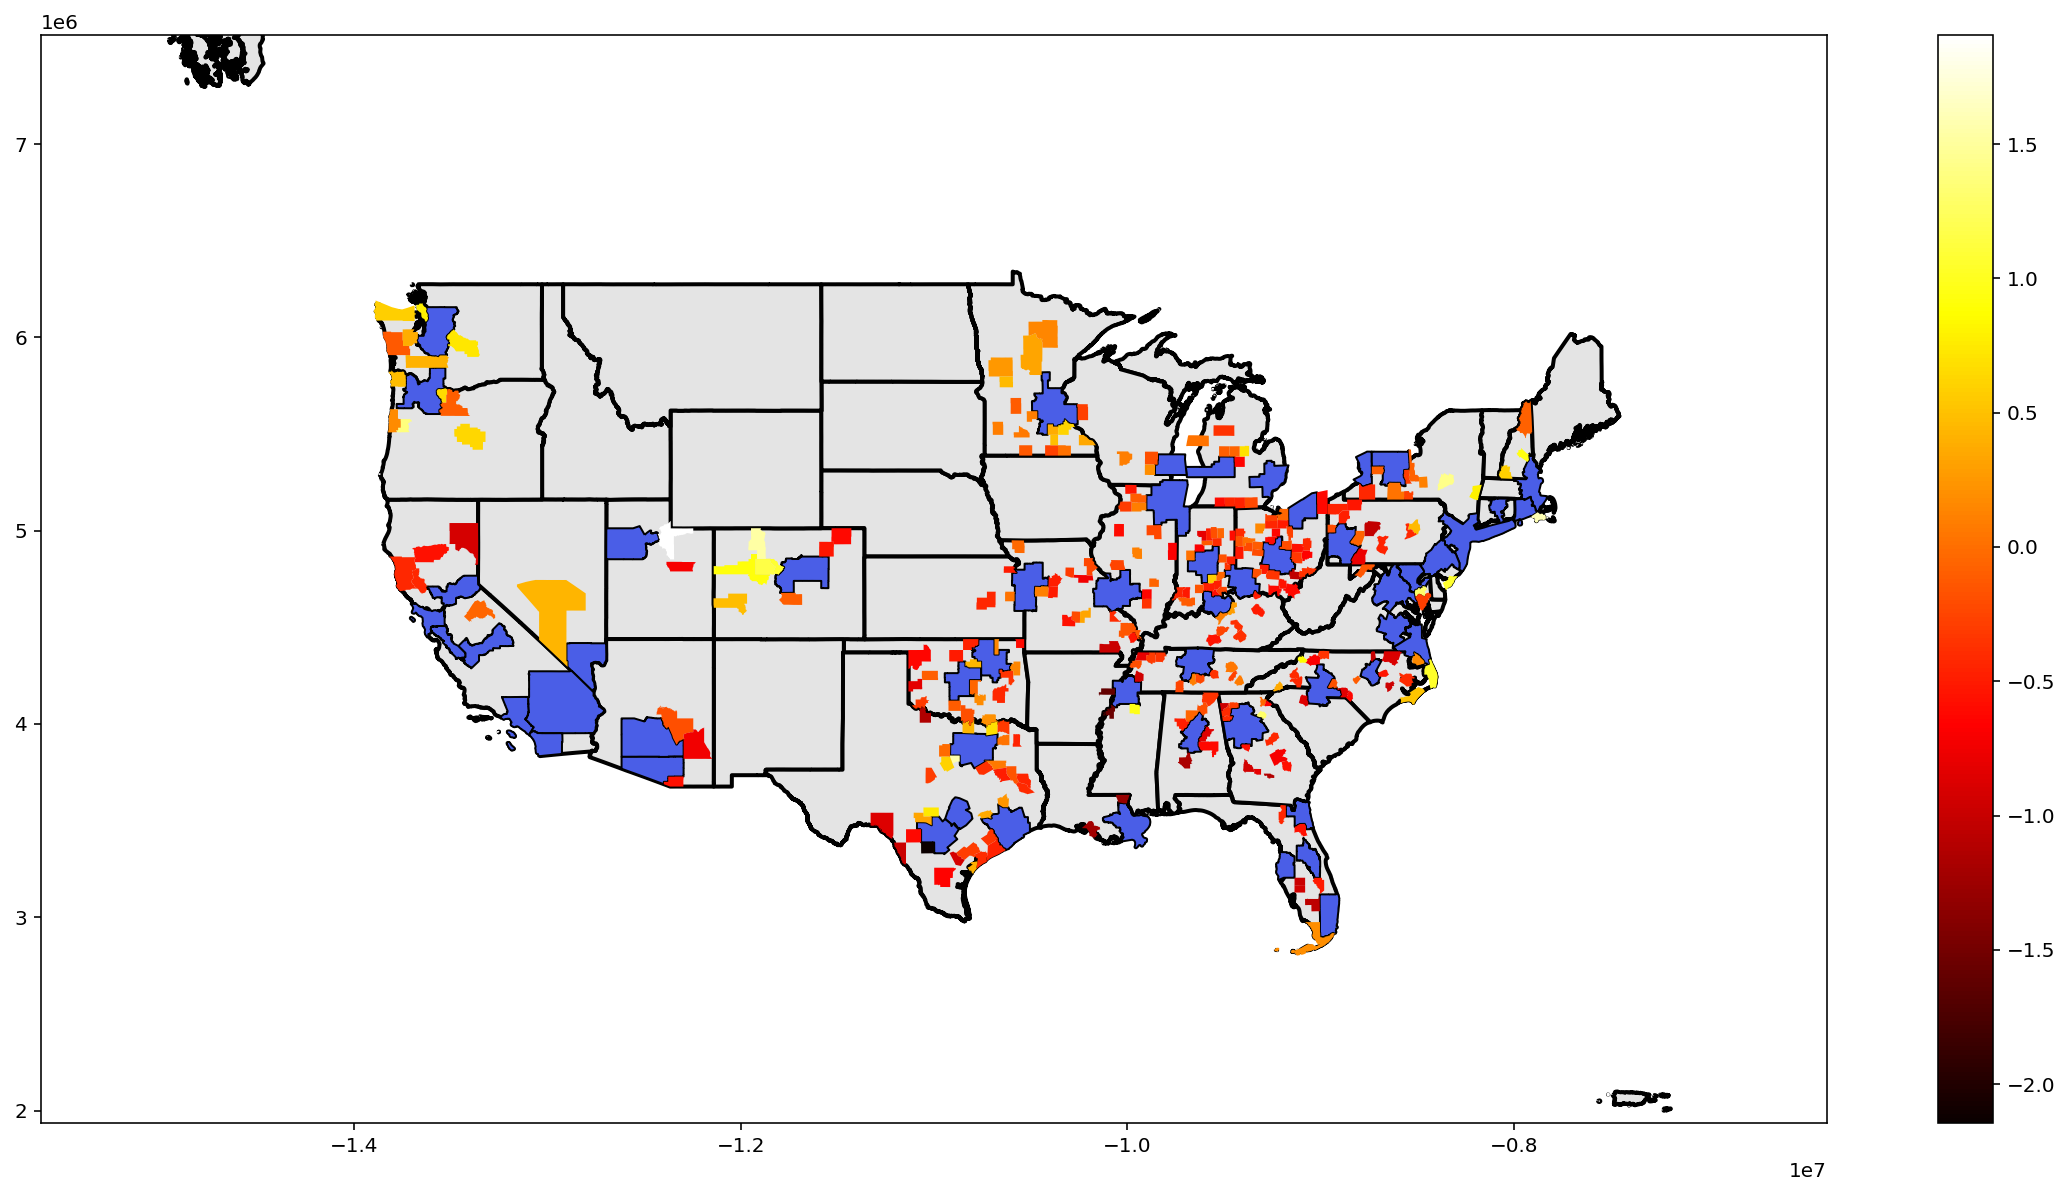

In [8]:
ax = plotUS()
df[df['metro']].plot(ax=ax, color="#4a5ee7", edgecolor="black", linewidth=1, label='Metro')
df[df['liminal']].plot(ax=ax, column='score', cmap='hot', legend=True);

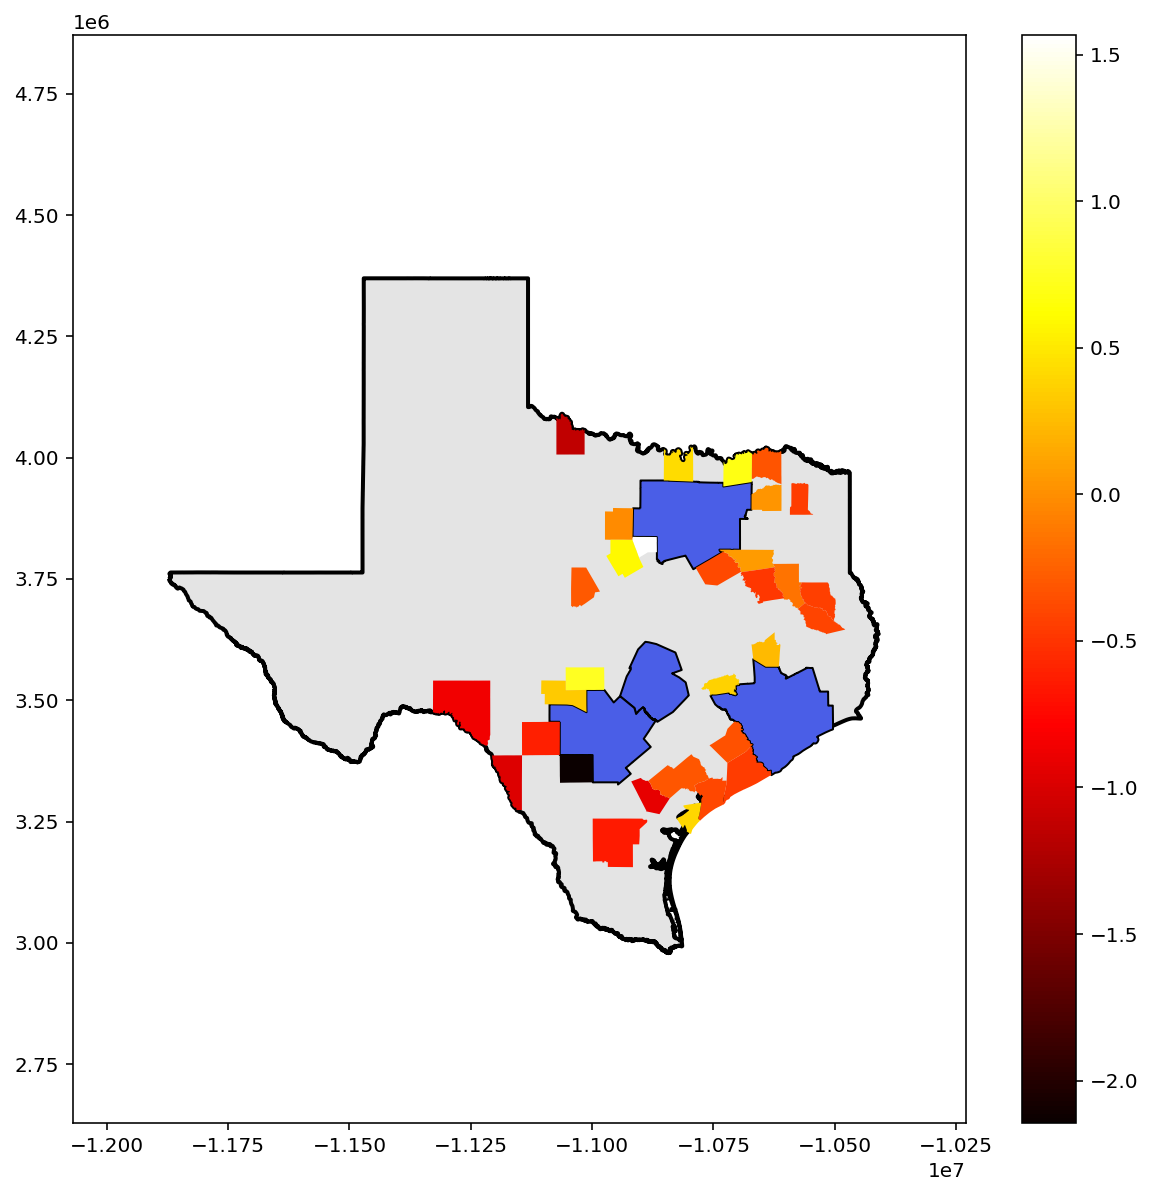

In [9]:
ax = plotTX()
df[df['metro'] & df['NAME'].str.contains(', TX')].plot(ax=ax, color="#4a5ee7", edgecolor="black", linewidth=1, label='Metro')
txLiminal = df[df['liminal'] & df['NAME'].str.contains(', TX')]
txLiminal.plot(ax=ax, column='score', cmap='hot', legend=True);

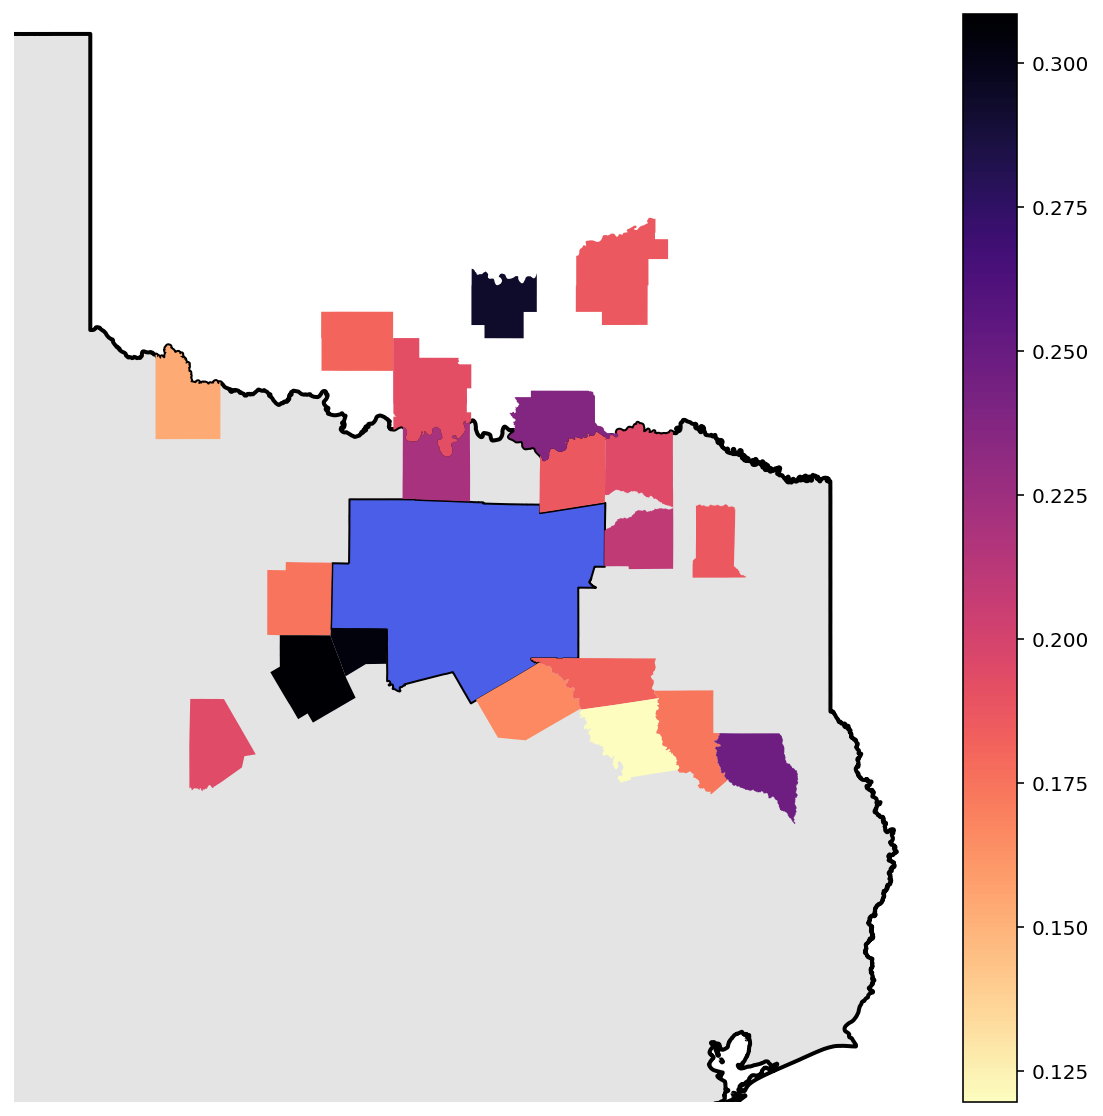

In [10]:
dfwCbsas = {10220, 11620, 11980, 14300, 15220, 18620, 20340, 20460, 23620, 24180, 27380, 32540, 33420, 34420, 34860, 37300, 37580, 44500, 44860, 46900}

ax = plotDFW()
df[df['metro'] & (df['CBSA'] == 19100)].plot(ax=ax, color="#4a5ee7", edgecolor="black", linewidth=1, label='Metro')
txLiminal = df[df['liminal'] & df['CBSA'].isin(dfwCbsas)]
txLiminal.plot(ax=ax, column='Pct_BS_Above', cmap='magma_r', legend=True);
plt.axis('off');